### Sigma-Free Conditional Ring Attractor Network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchdiffeq import odeint

In [7]:
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN, self).__init__()
        self.hidden_dim = hidden_dim
        
        # Initialize the first layer weights and biases
        thetas = torch.linspace(0, 2 * np.pi, hidden_dim)
        init_weights = torch.stack((torch.cos(thetas), torch.sin(thetas)), dim=1)  # Corrected shape
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True)
        self.fc1.weight = nn.Parameter(init_weights)
        self.fc1.bias = nn.Parameter(torch.zeros(hidden_dim))
        
        # Initialize the second layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# random initialized MLP model
class MLP_general(nn.Module):
    
    def __init__(self, input_dim, hidden_dims, output_dim, activation_fun=nn.ReLU):
        super(MLP_general, self).__init__()
        layers = []
        for i in range(len(hidden_dims)):
            if i == 0:
                layers.append(nn.Linear(input_dim, hidden_dims[i]))
            else:
                layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            layers.append(activation_fun())
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.net = nn.Sequential(*layers)
        # initialize weights
        for i in range(len(layers)):
            if isinstance(layers[i], nn.Linear):
                nn.init.xavier_uniform_(layers[i].weight)
                nn.init.zeros_(layers[i].bias)
        
    def forward(self, x):
        return self.net(x)

# random initialized MLP model
class MLP_radial_tie(nn.Module):
    
    def __init__(self, input_dim, hidden_dims, output_dim=1, activation_fun=nn.ReLU):
        super(MLP_radial_tie, self).__init__()
        layers = []
        for i in range(len(hidden_dims)):
            if i == 0:
                layers.append(nn.Linear(input_dim, hidden_dims[i]))
            else:
                layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
            layers.append(activation_fun())
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        self.net = nn.Sequential(*layers)
        # initialize weights
        for i in range(len(layers)):
            if isinstance(layers[i], nn.Linear):
                nn.init.xavier_uniform_(layers[i].weight)
                nn.init.zeros_(layers[i].bias)
        
    def forward(self, x):
        U = x[:, 0] # radial coordinate
        V = x[:, 1] # radial coordinate
        out = self.net(x)
        vec = torch.stack([U, V], dim=1) * out
        return vec
    
    
def generate_ellipsoid_orbit(n_points, a, b, theta=0, repeat_endpoint=False):
    """
    Generate a dataset of points on an ellipsoid centered at the origin.
    
    Parameters:
    - n_points: Number of points to generate.
    - a, b: Semi-major and semi-minor axes of the ellipsoid.
    - noise: Standard deviation of Gaussian noise to be added to the ellipsoid values.
    
    Returns:
    - A tuple of tensors (inputs, targets), where inputs are the coordinates of the points,
      and targets are the ellipsoid values (ideally close to 1, with some noise).
    """
    if repeat_endpoint:
        angles = torch.linspace(0, 2 * np.pi, n_points, )
    else:
        angles = torch.linspace(0, 2 * np.pi, n_points + 1, )
        angles = angles[:-1]
    x = a * torch.cos(angles) 
    y = b * torch.sin(angles) 
    # Rotate the points by an angle theta
    R = torch.tensor([[np.cos(theta), -np.sin(theta)], 
                      [np.sin(theta), np.cos(theta)]]).float()
    x, y = torch.matmul(R, torch.stack([x, y]))
    pnts = torch.stack([x, y], dim=1)
    return pnts


def generate_ellipsoid_dataset(n_points, a, b, noise=0.1, repeat_endpoint=False):
    """
    Generate a dataset of points on an ellipsoid centered at the origin.
    
    Parameters:
    - n_points: Number of points to generate.
    - a, b: Semi-major and semi-minor axes of the ellipsoid.
    - noise: Standard deviation of Gaussian noise to be added to the ellipsoid values.
    
    Returns:
    - A tuple of tensors (inputs, targets), where inputs are the coordinates of the points,
      and targets are the ellipsoid values (ideally close to 1, with some noise).
    """
    if repeat_endpoint:
        angles = torch.linspace(0, 2 * np.pi, n_points, )
    else:
        angles = torch.linspace(0, 2 * np.pi, n_points + 1, )
        angles = angles[:-1]
    x = a * torch.cos(angles) + torch.randn(n_points) * noise
    y = b * torch.sin(angles) + torch.randn(n_points) * noise
    inputs = torch.stack([x, y], dim=1)
    inputs_05 = 0.5 * torch.stack([x, y], dim=1)
    inputs_15 = 1.5 * torch.stack([x, y], dim=1)
    # targets = torch.ones(n_points,2) + torch.randn(n_points,2) * noise
    targets = torch.zeros(n_points,2) + torch.randn(n_points,2) * noise # inputstorch.zeros(n_points,2)
    targets_05 =  0.5 * inputs
    targets_15 = -0.5 * inputs
    inputs_cmb = torch.cat([inputs, inputs_05, inputs_15], dim=0)
    targets_cmb = torch.cat([targets, targets_05, targets_15], dim=0)
    return inputs_cmb, targets_cmb


def generate_ellipsoid_dataset_3_rings(n_points, a, b, theta=0, repeat_endpoint=False):
    """
    Generate a dataset of points on an ellipsoid centered at the origin.
    
    Parameters:
    - n_points: Number of points to generate.
    - a, b: Semi-major and semi-minor axes of the ellipsoid.
    - noise: Standard deviation of Gaussian noise to be added to the ellipsoid values.
    
    Returns:
    - A tuple of tensors (inputs, targets), where inputs are the coordinates of the points,
      and targets are the ellipsoid values (ideally close to 1, with some noise).
    """
    pnts = generate_ellipsoid_orbit(n_points, a, b, theta, repeat_endpoint)
    pnts_05 = 0.5 * pnts
    pnts_15 = 1.5 * pnts
    targets = torch.zeros(n_points,2)
    targets_05 =  0.5 * pnts
    targets_15 = -0.5 * pnts
    inputs_cmb = torch.cat([ pnts, pnts_05, pnts_15], dim=0)
    targets_cmb = torch.cat([targets, targets_05, targets_15], dim=0)
    return inputs_cmb, targets_cmb

### Get Training data points

In [3]:
# Generate the dataset
n_points = 500
a, b = 1, 1  # Semi-axes lengths for the ellipsoid
inputs_all = []
targets_all = []
cond_all = []
theta_list = np.linspace(0, 2 * np.pi, 37)[:-1]
for theta in theta_list:
    for a in [0.5, 1, 1.5, 2.0]:
        # Generate the dataset
        inputs, targets = generate_ellipsoid_dataset_3_rings(n_points, a, b, theta=theta, repeat_endpoint=False)
        # a, cos theta, sin theta
        cond = torch.tensor([a, np.cos(theta), np.sin(theta)]).repeat(3 * n_points, 1)
        inputs_all.append(inputs)
        targets_all.append(targets)
        cond_all.append(cond)
inputs_all = torch.cat(inputs_all, dim=0)
targets_all = torch.cat(targets_all, dim=0)
cond_all = torch.cat(cond_all, dim=0)

In [4]:
print(inputs_all.shape, targets_all.shape, cond_all.shape)

torch.Size([216000, 2]) torch.Size([216000, 2]) torch.Size([216000, 3])


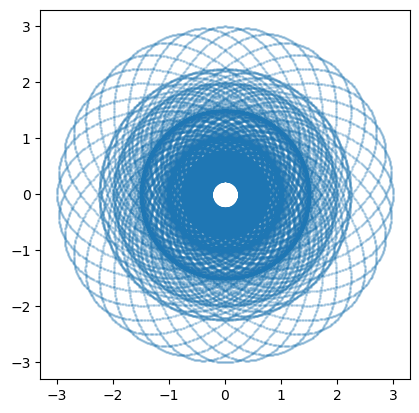

In [5]:
plt.scatter(inputs_all[:,0], inputs_all[:,1],s=1, alpha=0.1)
plt.axis("image")
plt.show()

### Train the network

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# Define the network, loss function, and optimizer
criterion = nn.MSELoss()
# Recreate the model with the corrected class
# model = TwoLayerNN(input_dim=2, hidden_dim=50, output_dim=2)
# model = MLP_general(input_dim=5, hidden_dims=[256,256,256,256,256,], output_dim=2, activation_fun=nn.ReLU)
# model = MLP_general(input_dim=5, hidden_dims=[256,256,256,256,256,], output_dim=2, activation_fun=nn.ReLU)
model = MLP_general(input_dim=5, hidden_dims=[512,512,512,512,512,], output_dim=2, activation_fun=nn.ReLU)
model.train().cuda()
# Redefine the optimizer because the model parameters have changed
optimizer = optim.Adam(model.parameters(), lr=0.001)
inpcond_all = torch.cat([inputs_all, cond_all], dim=1).cuda().float()
targets_all = targets_all.cuda().float()
# dataset = TensorDataset(inputs_all.cuda().float(), targets_all.cuda().float(), cond_all.cuda().float())
# dataloader = DataLoader(dataset, batch_size=60000, shuffle=False)
epochs = 1000
# Retrain the model with the corrected architecture
for epoch in range(epochs):
    optimizer.zero_grad()
    # for inputs, targets, cond in dataloader:
    outputs = model(inpcond_all)
    loss = criterion(outputs, targets_all)
    loss.backward()
    optimizer.step()
    if epoch % 25 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

final_loss = loss.item()
final_loss

Epoch 0/1000, Loss: 0.12035568058490753
Epoch 25/1000, Loss: 0.016626011580228806
Epoch 50/1000, Loss: 0.007375645451247692
Epoch 75/1000, Loss: 0.0023250188678503036
Epoch 100/1000, Loss: 0.003735488746315241
Epoch 125/1000, Loss: 0.0006535672582685947
Epoch 150/1000, Loss: 0.00043438078137114644
Epoch 175/1000, Loss: 0.00042855707579292357
Epoch 200/1000, Loss: 0.0002185115881729871
Epoch 225/1000, Loss: 0.00014977730461396277
Epoch 250/1000, Loss: 0.00010913583537330851
Epoch 275/1000, Loss: 8.959863771451637e-05
Epoch 300/1000, Loss: 7.490724965464324e-05
Epoch 325/1000, Loss: 0.0001265640603378415
Epoch 350/1000, Loss: 6.057244536350481e-05
Epoch 375/1000, Loss: 0.000515982392244041
Epoch 400/1000, Loss: 5.180730659049004e-05
Epoch 425/1000, Loss: 0.0010604043491184711
Epoch 450/1000, Loss: 9.39699966693297e-05
Epoch 475/1000, Loss: 3.830572313745506e-05
Epoch 500/1000, Loss: 2.8244598070159554e-05
Epoch 525/1000, Loss: 2.427100480417721e-05
Epoch 550/1000, Loss: 0.000297850288916

0.00014713792188558728

### Conditional input 

In [ ]:
model.eval().to('cuda')
dynamics_system = lambda t, x: model(torch.cat([x, cond_eval], dim=1))
# Time span for the simulation
t_span = torch.linspace(0, 100, 500).to("cuda")  # torch version of np.linspace
# generate random initial conditions
n_points = 1000
a_eval = 0.5
theta_eval = np.pi/6
cond_eval = torch.tensor([a_eval, np.cos(theta_eval), np.sin(theta_eval)]).repeat(n_points, 1)\
    .float().cuda()
x0 = torch.randn(n_points, 2).to('cuda')
with torch.no_grad():
    solution_tsr = odeint(dynamics_system, x0, t_span, method='dopri5').cpu() # dopri5
print(solution_tsr.shape)
solution_tsr = solution_tsr.permute(1, 2, 0) # batch, dim, time

torch.Size([500, 1000, 2])


(-3.4675740957260133,
 3.812025046348572,
 -3.7874218463897704,
 3.095066213607788)

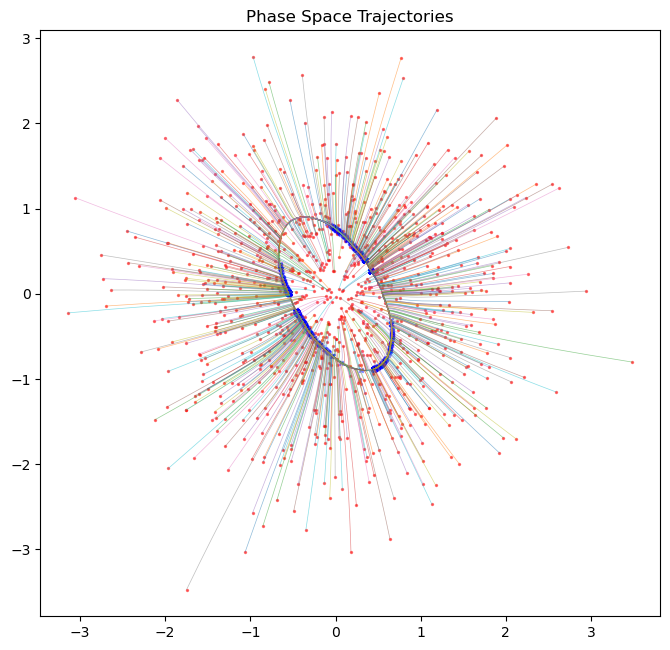

In [ ]:
ellips = generate_ellipsoid_orbit(100, a_eval, b, theta=theta_eval)
# Plotting the dynamics of the system
plt.figure(figsize=(8, 8))
plt.plot(ellips[:, 0], ellips[:, 1], c='green', lw=1, alpha=0.5)   
plt.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.5, lw=0.5)
plt.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=2, marker='o', alpha=0.5)
plt.scatter(solution_tsr[:, 0, -1], solution_tsr[:, 1, -1], c='blue', s=10, marker='x', alpha=0.5)
plt.title('Phase Space Trajectories')
plt.axis('image')

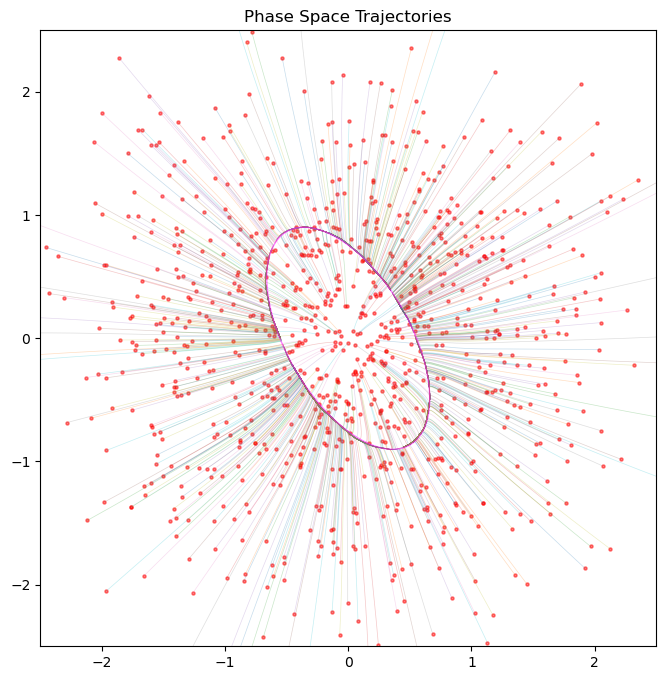

In [ ]:

import matplotlib.animation as animation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

traj_collection = ax.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.25, lw=0.5)
# Initialize the scatter plot for dynamic updates
scatter_dynamic = ax.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=5, marker='o', alpha=0.5)
# Initialize a scatter plot for static points
scatter_static = ax.plot(ellips[:, 0], ellips[:, 1], c='magenta', lw=1, alpha=0.5)   

# Set the axis limits and aspect ratio
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect('equal')
ax.set_title('Phase Space Trajectories')
# Set the axis limits

# Define the update function for the animation
def update(frame):
    # Update positions of the dynamic scatter plot
    scatter_dynamic.set_offsets(np.c_[solution_tsr[:, 0, frame], solution_tsr[:, 1, frame]])
    # Note: No need to clear the axes or re-draw static elements

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=solution_tsr.shape[2], interval=100)

# Save the animation as a GIF
# ani.save('particle_dynamics_dense_cond.gif', writer='pillow')
# ani.save('particle_dynamics_dense_cond.gif', writer='pillow')
# piece-wise linear dynamic system vector field.

### Time dependent conditional input

torch.Size([500, 1000, 2])


(-3.0943809509277345,
 3.6759844779968263,
 -3.8760116577148436,
 3.9025500297546385)

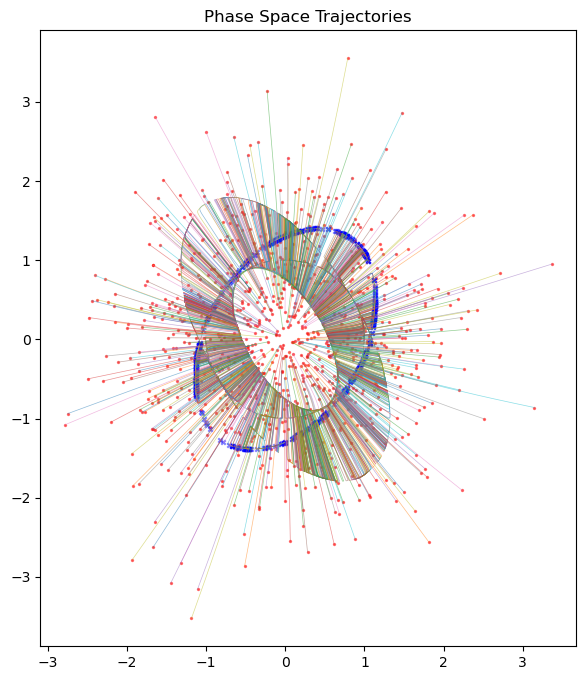

In [ ]:
model.eval().to('cuda')
# Time span for the simulation
t_span = torch.linspace(0, 100, 500).to("cuda")  # torch version of np.linspace
# generate random initial conditions
n_points = 1000
def get_a_theta(t):
    if t < 25:
        a_eval = 0.5
        theta_eval = np.pi/6
    elif t < 50:
        a_eval = 1
        theta_eval = np.pi/4
    elif t < 75:
        a_eval = 2
        theta_eval = np.pi * 2 / 3 
    else:
        a_eval = 1.5
        theta_eval = np.pi/3
    return a_eval, theta_eval

def cond_tsr_t(t):
    a_eval, theta_eval = get_a_theta(t)
    cond_eval = torch.tensor([a_eval, np.cos(theta_eval), np.sin(theta_eval)]).\
        expand(n_points, -1).float().cuda()
    return cond_eval

dynamics_system_t = lambda t, x: model(torch.cat([x, cond_tsr_t(t)], dim=1))
x0 = torch.randn(n_points, 2).to('cuda')
with torch.no_grad():
    solution_tsr = odeint(dynamics_system_t, x0, t_span, method='dopri5').cpu() # dopri5
print(solution_tsr.shape)
solution_tsr = solution_tsr.permute(1, 2, 0) # batch, dim, time
# cond_eval1 = torch.tensor([a_eval, np.cos(theta_eval), np.sin(theta_eval)]).\
#     repeat(n_points, 1).float().cuda()
ellips = generate_ellipsoid_orbit(100, a_eval, b, theta=theta_eval)
# Plotting the dynamics of the system
plt.figure(figsize=(8, 8))
plt.plot(ellips[:, 0], ellips[:, 1], c='green', lw=1, alpha=0.5)   
plt.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.5, lw=0.5)
plt.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=2, marker='o', alpha=0.5)
plt.scatter(solution_tsr[:, 0, -1], solution_tsr[:, 1, -1], c='blue', s=10, marker='x', alpha=0.5)
plt.title('Phase Space Trajectories')
plt.axis('image')

## Tied radial network

In [18]:
from torch.utils.data import TensorDataset, DataLoader
# Define the network, loss function, and optimizer
criterion = nn.MSELoss()
# Recreate the model with the corrected class
# model = TwoLayerNN(input_dim=2, hidden_dim=50, output_dim=2)
# model = MLP_general(input_dim=5, hidden_dims=[256,256,256,256,256,], output_dim=2, activation_fun=nn.ReLU)
# model = MLP_general(input_dim=5, hidden_dims=[256,256,256,256,256,], output_dim=2, activation_fun=nn.ReLU)
# model = MLP_general(input_dim=5, hidden_dims=[512,512,512,512,512,], output_dim=2, activation_fun=nn.ReLU)
# model = MLP_radial_tie(input_dim=5, hidden_dims=[256,256,256,256,256,], output_dim=1, activation_fun=nn.ReLU)
model = MLP_radial_tie(input_dim=5, hidden_dims=[512,512,512,512,512,], output_dim=1, activation_fun=nn.ReLU)
model.train().cuda()
# Redefine the optimizer because the model parameters have changed
optimizer = optim.Adam(model.parameters(), lr=0.001)
inpcond_all = torch.cat([inputs_all, cond_all], dim=1).cuda().float()
targets_all = targets_all.cuda().float()
# dataset = TensorDataset(inputs_all.cuda().float(), targets_all.cuda().float(), cond_all.cuda().float())
# dataloader = DataLoader(dataset, batch_size=60000, shuffle=False)
epochs = 1000
# Retrain the model with the corrected architecture
for epoch in range(epochs):
    optimizer.zero_grad()
    # for inputs, targets, cond in dataloader:
    outputs = model(inpcond_all)
    loss = criterion(outputs, targets_all)
    loss.backward()
    optimizer.step()
    if epoch % 25 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

final_loss = loss.item()
final_loss

Epoch 0/1000, Loss: 0.11240196228027344
Epoch 25/1000, Loss: 0.029342465102672577
Epoch 50/1000, Loss: 0.008382308296859264
Epoch 75/1000, Loss: 0.0030837245285511017
Epoch 100/1000, Loss: 0.0007985403062775731
Epoch 125/1000, Loss: 0.00020243407925590873
Epoch 150/1000, Loss: 0.00011759348126361147
Epoch 175/1000, Loss: 8.09050616226159e-05
Epoch 200/1000, Loss: 6.130769179435447e-05
Epoch 225/1000, Loss: 0.00042729434790089726
Epoch 250/1000, Loss: 7.149711746023968e-05
Epoch 275/1000, Loss: 4.0505354263586923e-05
Epoch 300/1000, Loss: 3.176866448484361e-05
Epoch 325/1000, Loss: 6.324539572233334e-05
Epoch 350/1000, Loss: 0.0009453199454583228
Epoch 375/1000, Loss: 0.0001312878739554435
Epoch 400/1000, Loss: 2.7159443561686203e-05
Epoch 425/1000, Loss: 2.202823816332966e-05
Epoch 450/1000, Loss: 1.8524318875279278e-05
Epoch 475/1000, Loss: 1.6296222383971326e-05
Epoch 500/1000, Loss: 1.4603790987166576e-05
Epoch 525/1000, Loss: 1.3246105481812265e-05
Epoch 550/1000, Loss: 1.212309507

6.050562660675496e-06

### Sampling

In [19]:
model.eval().to('cuda')
dynamics_system = lambda t, x: model(torch.cat([x, cond_eval], dim=1))
# Time span for the simulation
t_span = torch.linspace(0, 100, 500).to("cuda")  # torch version of np.linspace
# generate random initial conditions
n_points = 1000
a_eval = 0.5
theta_eval = np.pi/6
cond_eval = torch.tensor([a_eval, np.cos(theta_eval), np.sin(theta_eval)]).repeat(n_points, 1)\
    .float().cuda()
x0 = torch.randn(n_points, 2).to('cuda')
with torch.no_grad():
    solution_tsr = odeint(dynamics_system, x0, t_span, method='dopri5').cpu() # dopri5
print(solution_tsr.shape)
solution_tsr = solution_tsr.permute(1, 2, 0) # batch, dim, time

torch.Size([500, 1000, 2])


(-3.2952088475227357, 3.708957827091217, -3.391976809501648, 3.507166361808777)

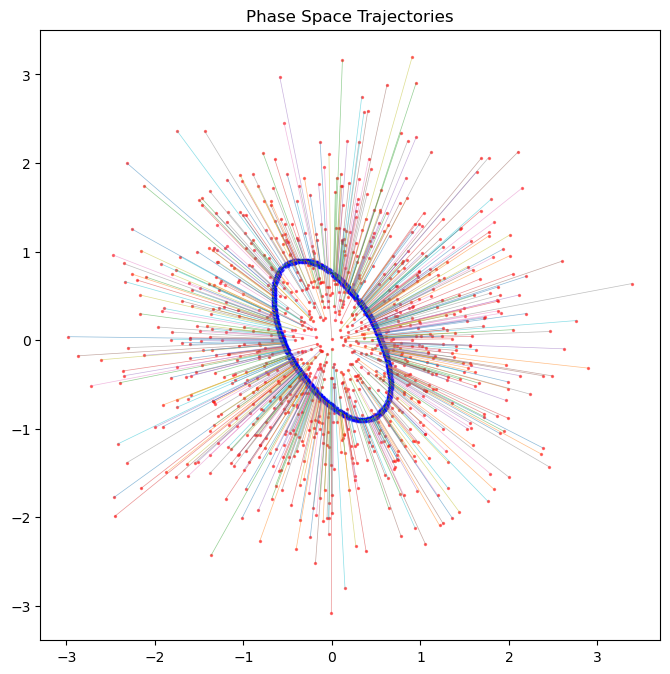

In [20]:
ellips = generate_ellipsoid_orbit(100, a_eval, b, theta=theta_eval)
# Plotting the dynamics of the system
plt.figure(figsize=(8, 8))
plt.plot(ellips[:, 0], ellips[:, 1], c='green', lw=1, alpha=0.5)   
plt.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.5, lw=0.5)
plt.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=2, marker='o', alpha=0.5)
plt.scatter(solution_tsr[:, 0, -1], solution_tsr[:, 1, -1], c='blue', s=10, marker='x', alpha=0.5)
plt.title('Phase Space Trajectories')
plt.axis('image')

torch.Size([500, 1000, 2])


(-3.050218868255615, 3.3501799583435057, -4.289237606525421, 3.515661585330963)

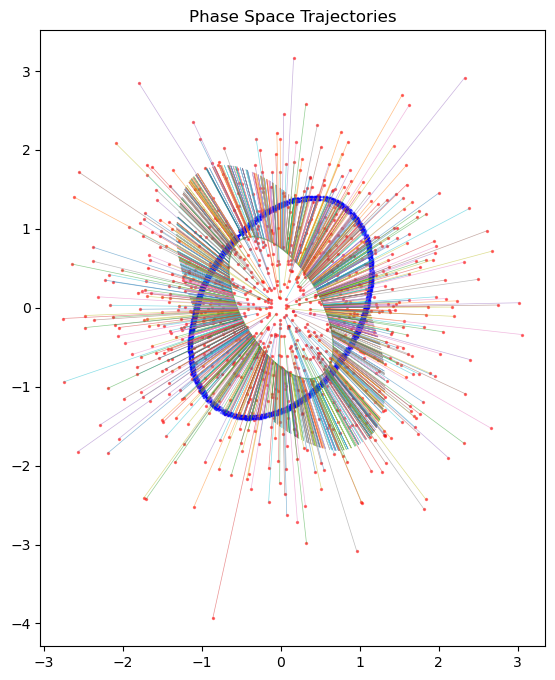

In [21]:
model.eval().to('cuda')
# Time span for the simulation
t_span = torch.linspace(0, 100, 500).to("cuda")  # torch version of np.linspace
# generate random initial conditions
n_points = 1000
def get_a_theta(t):
    if t < 25:
        a_eval = 0.5
        theta_eval = np.pi/6
    elif t < 50:
        a_eval = 1
        theta_eval = np.pi/4
    elif t < 75:
        a_eval = 2
        theta_eval = np.pi * 2 / 3 
    else:
        a_eval = 1.5
        theta_eval = np.pi/3
    return a_eval, theta_eval

def cond_tsr_t(t):
    a_eval, theta_eval = get_a_theta(t)
    cond_eval = torch.tensor([a_eval, np.cos(theta_eval), np.sin(theta_eval)]).\
        expand(n_points, -1).float().cuda()
    return cond_eval

dynamics_system_t = lambda t, x: model(torch.cat([x, cond_tsr_t(t)], dim=1))
x0 = torch.randn(n_points, 2).to('cuda')
with torch.no_grad():
    solution_tsr = odeint(dynamics_system_t, x0, t_span, method='dopri5').cpu() # dopri5
print(solution_tsr.shape)
solution_tsr = solution_tsr.permute(1, 2, 0) # batch, dim, time
# cond_eval1 = torch.tensor([a_eval, np.cos(theta_eval), np.sin(theta_eval)]).\
#     repeat(n_points, 1).float().cuda()
ellips = generate_ellipsoid_orbit(100, a_eval, b, theta=theta_eval)
# Plotting the dynamics of the system
plt.figure(figsize=(8, 8))
plt.plot(ellips[:, 0], ellips[:, 1], c='green', lw=1, alpha=0.5)   
plt.plot(solution_tsr[:, 0].T, solution_tsr[:, 1].T, alpha=0.5, lw=0.5)
plt.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], c='r', s=2, marker='o', alpha=0.5)
plt.scatter(solution_tsr[:, 0, -1], solution_tsr[:, 1, -1], c='blue', s=10, marker='x', alpha=0.5)
plt.title('Phase Space Trajectories')
plt.axis('image')

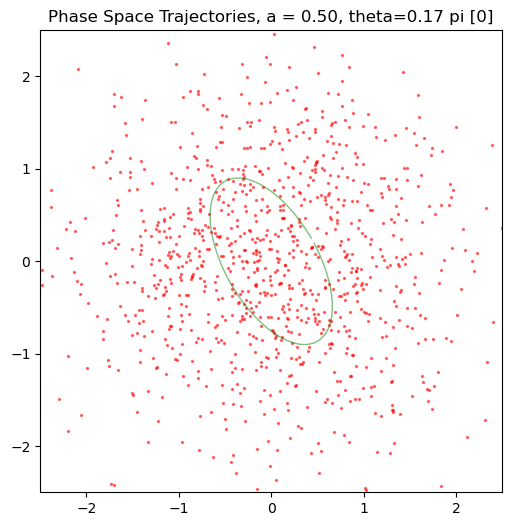

In [22]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect('equal')
scatter_dynamics = ax.scatter(solution_tsr[:, 0, 0], solution_tsr[:, 1, 0], 
                c='r', s=2, marker='o', alpha=0.5)
target_manifold = ax.plot(ellips[:, 0], ellips[:, 1], c='green', lw=1, alpha=0.5)   
# Define the update function for the animation
def update(frame):
    # Add your code here to update the plot for each frame
    scatter_dynamics.set_offsets(np.c_[solution_tsr[:, 0, frame], solution_tsr[:, 1, frame]])
    a_eval, theta_eval = get_a_theta(t_span[frame].item())
    ellips = generate_ellipsoid_orbit(100, a_eval, b, theta=theta_eval)
    target_manifold[0].set_data(ellips[:, 0], ellips[:, 1])
    ax.set_title('Phase Space Trajectories, a = %.2f, theta=%.2f pi [%d]' % (a_eval, theta_eval / np.pi, frame))
    # Note: No need to clear the axes or re-draw static elements
# Create the animation
ani = animation.FuncAnimation(fig, update, frames=solution_tsr.shape[2], interval=33)

# Create the animation
# ani = animation.FuncAnimation(fig, update, frames=range(500), interval=200)

# import imageio
# frames = []
# # Generate each frame and add it to the list
# for frame in range(solution_tsr.shape[2]):
#     img = update(frame)
#     frames.append(img)

# Save the frames as an mp4
ani.save(f'particle_dynamics_dense_cond_radial_tie.mp4', writer='ffmpeg')
# imageio.mimsave('particle_dynamics_dense_radial_tie.mp4', frames, fps=10)
# Display the animation
# plt.show()
